## Setup & Imports


In [1]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

In [2]:
import os
import shutil
import urllib
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Import Dataset

In [3]:
data_path = "https://raw.githubusercontent.com/nee2shaji/IIIT_Sem4/main/train_X.txt"
response = urllib.request.urlopen(data_path)
train_X = []
for line in response:
  train_X.append([line.decode("utf-8").strip()])

data_path = "https://raw.githubusercontent.com/nee2shaji/IIIT_Sem4/main/train_y.csv"
response = urllib.request.urlopen(data_path)
train_y = []
for line in response:
  train_y.append(line.decode("utf-8").strip().split(','))

# train_X =[['राम और सीता उसके लिए कलम लेने बाजार जा रहे हैं'],
#          ['श्याम खुद कमरा साफ़ करता है'],
#          ['राम पुस्तकालय से अपनी पुस्तक लेने जा रहे हैं'],
#          ['मीरा ने राम को उनसे उपहार स्वीकार करने के लिए कहा'],
#          ['जेनिफर अपना काम खुद करती हैं']]
# train_y = [[1,0,2,1,0,0,0,0,0,0,0],
#            [1,1,0,0,0,0],
#            [1,0,0,1,0,0,0,0,0],
#            [1,0,2,0,1,0,0,0,0,0],
#            [1,1,0,0,0,0]]
train_X = np.array(train_X)
train_y = np.array(pad_sequences(train_y, maxlen=128, padding='pre'))
print(train_X)
print(train_y)


[['श्याम खुद कमरा साफ़ करता है']
 ['राम और सीता उसके लिए कलम लेने बाजार जा रहे हैं']
 ['राम पुस्तकालय से अपनी पुस्तक लेने जा रहे हैं']
 ['मीरा ने राम को उनसे उपहार स्वीकार करने के लिए कहा']
 ['कलाकारों ने स्वयं वेशभूषा बनाकर स्थानीय रंगमंच के पैसे बचाए']
 ['जेनिफर अपना काम खुद करती हैं']
 ['बच्चों ने खुद से छुट्टी की सजावट की']
 ['राम मीरा को प्रभावित करना चाहते थे , इसलिए उन्होंने खुद एक केक पकाया']
 ['रॉबर्ट एक राजा है जो सात राज्यों पर शासन करता है']
 ['रॉबर्ट केवल जुडी पर भरोसा करता है जो उसका मित्र है']
 ['मुझे टेबल पर जो किताब है वो दे दो']
 ['मारिया ने रॉबर्ट से कहा कि वह एक अच्छा इंसान है']
 ['हमारी बिल्ली हर भोजन के बाद खुद को धोती थी']
 ['रिया ने खुद को गर्म तौलिया से सुखा लिया']
 ['निया ने खुद कार पार्क की']
 ['लुसी खुश थी क्योंकि वह जिम गई थी']
 ['केंडल जिम गई थी जबकि उसका कुत्ता घर पर ही था']
 ['बच्चे भूखे थे , इसलिए मीरा ने उनके लिए खाना बनाया']
 ['कुत्ते दयालु हैं , हमें उनसे प्यार करना चाहिए']
 ['राम चाहते हैं कि श्याम उनकी परीक्षा के लिए अध्ययन करे']]
[[0 0 0 ... 0 0 0

## BERT Model

In [4]:

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [6]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['sequence_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.LSTM(100, return_sequences=True)(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None)(net)
  return tf.keras.Model(text_input, net)

In [14]:
classifier_model = build_classifier_model()

## Train Model

In [9]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalCrossentropy()

In [10]:
classifier_model.compile(optimizer='adam',
                         loss=loss,
                         metrics='accuracy')
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  177853441   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [11]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_X,
                               y=train_y,
                               epochs=100)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 20.2933 - accuracy: 0.8078
Epoch 2/100
1/1 [==============================] - 1s 609ms/step - loss: 14.7204 - accuracy: 0.9805
Epoch 3/100
1/1 [==============================] - 1s 630ms/step - loss: 14.5176 - accuracy: 0.9805
Epoch 4/100
1/1 [==============================] - 1s 621ms/step - loss: 14.7697 - accuracy: 0.0152
Epoch 5/100
1/1 [==============================] - 1s 628ms/step - loss: 14.8072 - accuracy: 0.0156
Epoch 6/100
1/1 [==============================] - 1s 626ms/step - loss: 14.7684 - accuracy: 0.0152
Epoch 7/100
1/1 [==============================] - 1s 623ms/step - loss: 14.7877 - accuracy: 0.0152
Epoch 8/100
1/1 [==============================] - 1s 628ms/step - loss: 14.7558 - accuracy: 0.0152
Epoch 9/100
1/1 [==============================] - 1s 629ms/step - loss: 14.7727 - accuracy: 0.0152
Epoch 10/100
1/1 

### Plot the accuracy and loss

dict_keys(['loss', 'accuracy'])


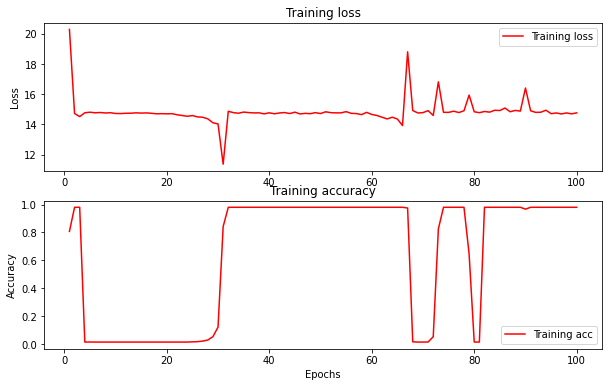

In [12]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')